# Imports

In [1]:
# Importing necessary libraries
import numpy as np
# Importing necessary libraries
import time
# Importing necessary libraries
import torch
# Importing necessary libraries
import torch.nn as nn
# Importing necessary libraries
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
# Importing necessary libraries
import torch.nn.init as init
# Importing necessary libraries
import matplotlib.pyplot as plt
# Importing necessary libraries
import seaborn as sns

# Settings and Dataset

In [2]:
batch_size = 128

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), 
]), download=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  
]), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

100%|██████████| 170498071/170498071 [00:21<00:00, 8031630.22it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


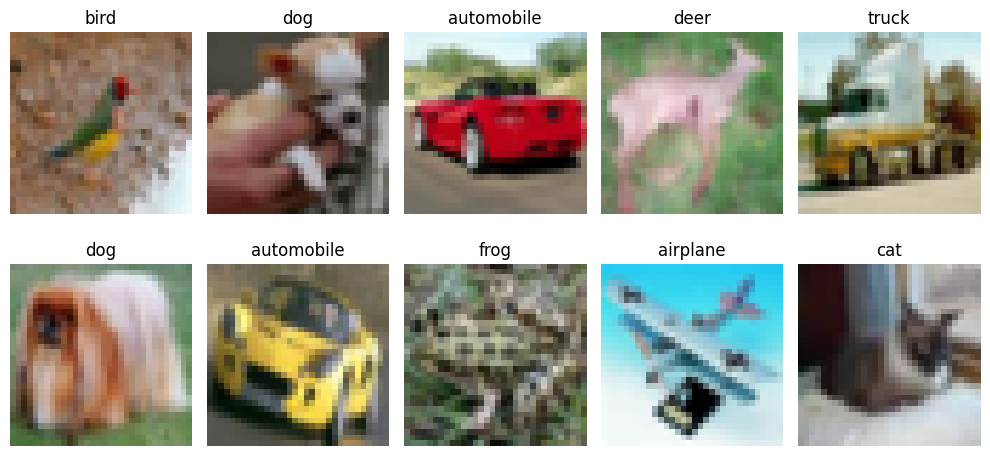

In [3]:
# Get an iterator from the training data loader
dataiter = iter(train_loader)
# Retrieve the next batch of images and labels
images, labels = next(dataiter)

# Define the mean pixel values for normalization
mean = np.array([0.4914, 0.4822, 0.4465])
# Define the standard deviation for normalization
std = np.array([0.2023, 0.1994, 0.2010])
# Convert images to numpy array and adjust dimensions
images = images.numpy().transpose((0, 2, 3, 1))  
# De-normalize the images
images = std * images + mean  
# Clip pixel values to be within valid range
images = np.clip(images, 0, 1) 

# Define class labels for CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create subplots for displaying images
fig, axes = plt.subplots(2, 5, figsize=(10, 5)) 
axes = axes.flatten()
# Loop through the first 10 images in the batch
for i in range(10): 
# Display the image
    axes[i].imshow(images[i])
# Set the title of each subplot based on the label
    axes[i].set_title(class_names[labels[i].item()])
# Remove axis ticks and labels for better visualization
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
# Display the plot
plt.show()

In [13]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

random_seed = 1
learning_rate = 0.01
num_epochs = 39 #15,000 steps

Device: cuda:0


# Vanilla Model

## Model

In [14]:
class VGG(torch.nn.Module):

    def __init__(self,num_classes=10):
        super(VGG, self).__init__()
     
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )     
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
      
        self.classifier = nn.Sequential(
            nn.Linear(512*2*2, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)  
         
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        
        x = torch.flatten(x, start_dim=1) 
            
        x = self.classifier(x)
        
        return x

In [15]:
torch.manual_seed(random_seed)
model = VGG()
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

## Training and Testing

In [16]:
activations = {"block_2_1": [], "block_4_1": []}
record_activations = False 
def hook_fn(module, input, output):
    global record_activations
    if record_activations:
        if module == model.block_2[1]:  
            activations["block_2_1"].append(output.detach().cpu().numpy())
        elif module == model.block_4[1]:  
            activations["block_4_1"].append(output.detach().cpu().numpy())

In [17]:
hook_standard_2_1 = model.block_2[1].register_forward_hook(hook_fn)
hook_standard_4_1 = model.block_4[1].register_forward_hook(hook_fn)

In [ ]:
train_acc_standard = []
test_acc_standard = []
loss_values = []  
loss_perturbated = [] 
steps = 0
eta=.4

for epoch in range(num_epochs):
    total_train=0
    correct_train = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        model.train()
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())
        optimizer.zero_grad()
        loss.backward()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        train_acc_standard.append(train_accuracy)

        model.eval()
        initial_weights = [p.clone().detach() for p in model.parameters()]
        gradients = [p.grad.clone() for p in model.parameters()] 
        with torch.no_grad():
            for p, g in zip(model.parameters(), gradients):
                p += eta * g  

            new_outputs = model(images)
            new_loss = criterion(new_outputs, labels).item()
            loss_perturbated.append(new_loss)

            for p, p_init in zip(model.parameters(), initial_weights):
                p.copy_(p_init)
        model.train()

        optimizer.step()

        if batch_idx==0:
            random_index = torch.randint(0, images.size(0), (1,)).item()
            sample_input = images[random_index].unsqueeze(0).to(DEVICE)
            model.eval()
            with torch.no_grad():
                record_activations = True  
                model(sample_input)  
                record_activations = False 

        model.train()

        steps += 1
        if steps % 500 == 0:
            model.eval()
            correct_test = 0
            total_test = 0
            with torch.no_grad():
                for test_images, test_labels in test_loader:
                    test_images, test_labels = test_images.to(DEVICE), test_labels.to(DEVICE)
                    test_outputs = model(test_images)
                    _, test_predicted = torch.max(test_outputs, 1)
                    total_test += test_labels.size(0)
                    correct_test += (test_predicted == test_labels).sum().item()
            test_accuracy = 100 * correct_test / total_test
            test_acc_standard.append(test_accuracy)
            print(f"Step [{steps}], Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/39], Loss: 2.0576
Step [500], Train Acc: 31.12%, Test Acc: 40.14%
Epoch [2/39], Loss: 1.5539
Step [1000], Train Acc: 39.31%, Test Acc: 46.12%
Epoch [3/39], Loss: 1.6668
Step [1500], Train Acc: 45.11%, Test Acc: 51.53%
Epoch [4/39], Loss: 1.4013


In [9]:
hook_standard_2_1.remove()
hook_standard_4_1.remove()

In [10]:
activations_block_2_1 = [np.array(epoch_act).flatten() for epoch_act in activations["block_2_1"]]
activations_block_4_1 = [np.array(epoch_act).flatten() for epoch_act in activations["block_4_1"]]

## Testing

In [14]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 73.29%


# BatchNorm Model

## Model

In [15]:
class VGG_BatchNorm(torch.nn.Module):

    def __init__(self, num_classes=10):
        super(VGG_BatchNorm, self).__init__()
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=1), 
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),        
                nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )
        
        self.block_4 = nn.Sequential(   
                nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),        
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),        
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        self.classifier = nn.Sequential(
            nn.Linear(512*2*2, 512),
            nn.BatchNorm1d(512), 
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),  
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)  

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = torch.flatten(x, start_dim=1) 
        x = self.classifier(x)
        return x

In [16]:
torch.manual_seed(random_seed)
model_BatchNorm = VGG_BatchNorm()

model_BatchNorm = model_BatchNorm.to(DEVICE)

criterion_BatchNorm = nn.CrossEntropyLoss()
optimizer_BatchNorm = torch.optim.SGD(model_BatchNorm.parameters(), lr=learning_rate)  

## Training and Testing

In [17]:
activations_BatchNorm = {"block_2_2": [], "block_4_2": []}
record_activations_BatchNorm = False  

def hook_fn_BatchNorm(module, input, output):
    global record_activations_BatchNorm
    if record_activations_BatchNorm: 
        if module == model_BatchNorm.block_2[2]:  
            activations_BatchNorm["block_2_2"].append(output.detach().cpu().numpy())
        elif module == model_BatchNorm.block_4[2]:  
            activations_BatchNorm["block_4_2"].append(output.detach().cpu().numpy())

In [18]:
hook_batchnorm_2_2 = model_BatchNorm.block_2[2].register_forward_hook(hook_fn_BatchNorm)
hook_batchnorm_4_2 = model_BatchNorm.block_4[2].register_forward_hook(hook_fn_BatchNorm)

In [19]:
train_acc_BatchNorm = []
test_acc_BatchNorm = []
loss_values_BatchNorm = []  
loss_perturbated_BatchNorm = []
steps = 0

for epoch in range(num_epochs):
    total_train=0
    correct_train = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        model_BatchNorm.train()
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        outputs = model_BatchNorm(images)
        loss = criterion_BatchNorm(outputs, labels)
        loss_values_BatchNorm.append(loss.item())
        optimizer_BatchNorm.zero_grad()
        loss.backward()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        train_acc_BatchNorm.append(train_accuracy)


        model_BatchNorm.eval()
        initial_weights = [p.clone().detach() for p in model_BatchNorm.parameters()]
        gradients = [p.grad.clone() for p in model_BatchNorm.parameters()] 
        with torch.no_grad():
            for p, g in zip(model_BatchNorm.parameters(), gradients):
                p += eta * g  

            new_outputs = model_BatchNorm(images)
            new_loss = criterion_BatchNorm(new_outputs, labels).item()
            loss_perturbated.append(new_loss)

            for p, p_init in zip(model_BatchNorm.parameters(), initial_weights):
                p.copy_(p_init)
        model_BatchNorm.train()

        optimizer_BatchNorm.step()

        if batch_idx==0:
            random_index = torch.randint(0, images.size(0), (1,)).item()
            sample_input = images[random_index].unsqueeze(0).to(DEVICE)
            model_BatchNorm.eval()
            with torch.no_grad():
                record_activations_BatchNorm = True  
                model_BatchNorm(sample_input) 
                record_activations_BatchNorm = False  
            model_BatchNorm.train()

        steps += 1
        if steps % 500 == 0:
            model_BatchNorm.eval()
            correct_test = 0
            total_test = 0
            with torch.no_grad():
                for test_images, test_labels in test_loader:
                    test_images, test_labels = test_images.to(DEVICE), test_labels.to(DEVICE)
                    test_outputs = model_BatchNorm(test_images)
                    _, test_predicted = torch.max(test_outputs, 1)
                    total_test += test_labels.size(0)
                    correct_test += (test_predicted == test_labels).sum().item()
            test_accuracy = 100 * correct_test / total_test
            test_acc_BatchNorm.append(test_accuracy)
            print(f"Step [{steps}], Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")

    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

KeyboardInterrupt: 

In [20]:
hook_batchnorm_2_2.remove()
hook_batchnorm_2_2.remove()

In [21]:
activations_block_2_2_BatchNorm = [np.array(epoch_act).flatten() for epoch_act in activations_BatchNorm["block_2_2"]]
activations_block_4_2_BatchNorm = [np.array(epoch_act).flatten() for epoch_act in activations_BatchNorm["block_4_2"]]

## Testing

In [26]:
model_BatchNorm.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_BatchNorm(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 51.52%


# Comparison

## Training and Testing Accuracy

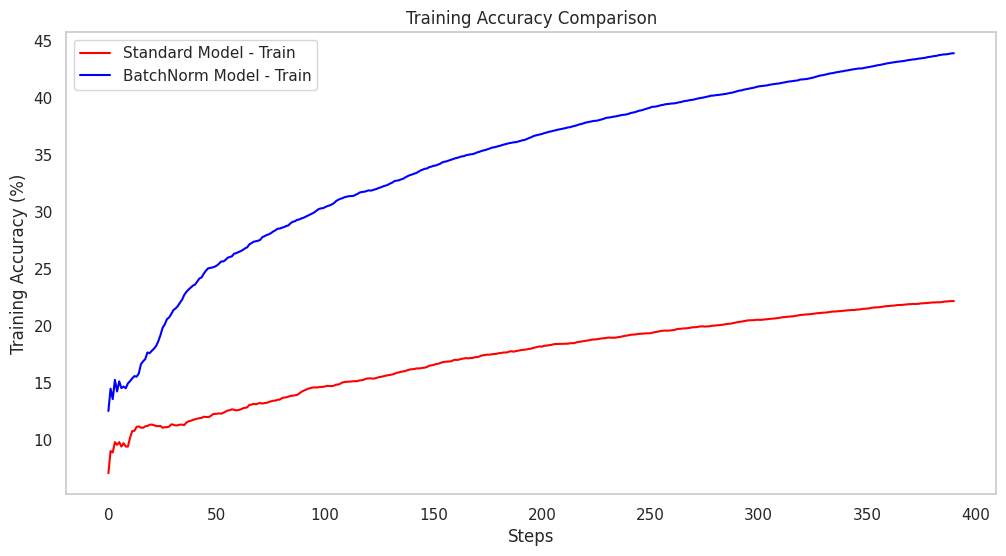

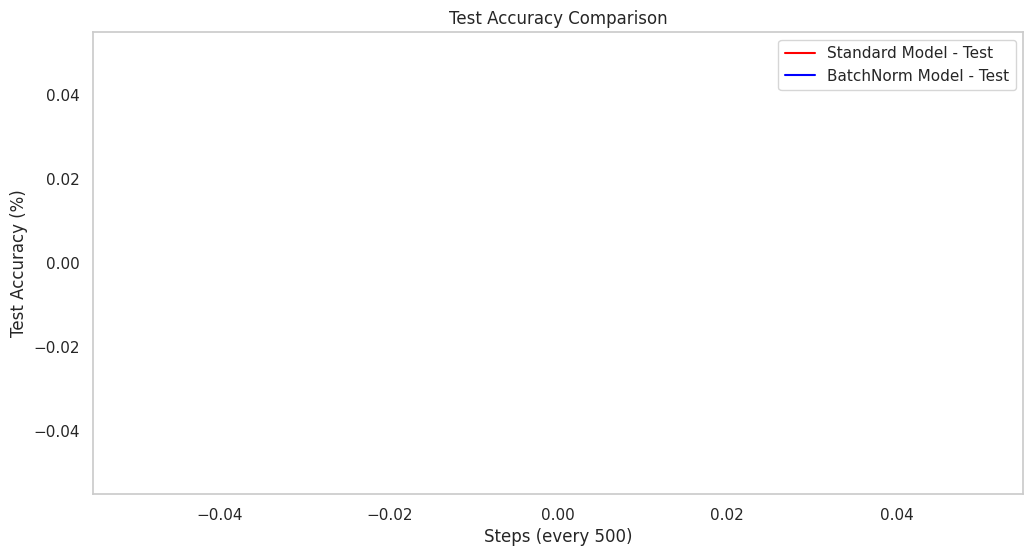

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(train_acc_standard, label='Standard Model - Train', linestyle='-', color='red')
plt.plot(train_acc_BatchNorm, label='BatchNorm Model - Train', linestyle='-', color='blue')
plt.xlabel('Steps')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid()
# Display the plot
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_acc_standard, label='Standard Model - Test', linestyle='-', color='red')
plt.plot(test_acc_BatchNorm, label='BatchNorm Model - Test', linestyle='-', color='blue')
plt.xlabel('Steps (every 500)')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.legend()
plt.grid()
# Display the plot
plt.show()

## Activations distribution

In [ ]:
def plot_superposed_distributions(activations_list, layer_name,standard):
    plt.figure(figsize=(8, 6))

    for activations in activations_list:
        sns.kdeplot(activations)
    if standard:
        plt.title(f"Activation Distributions for {layer_name} of standard model (Superposed)")
    else:
        plt.title(f"Activation Distributions for {layer_name} of BatchNorm model (Superposed)")
    plt.xlabel("Activation Value")
    plt.ylabel("Density")
    plt.ylim(0, 4)
# Display the plot
    plt.show()

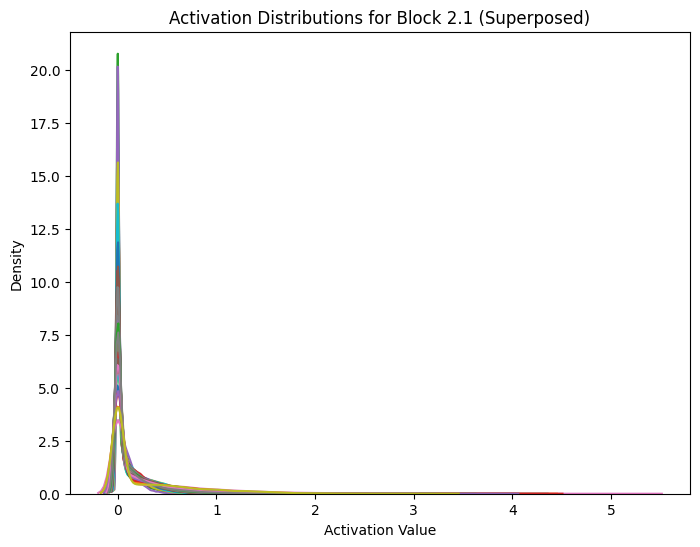

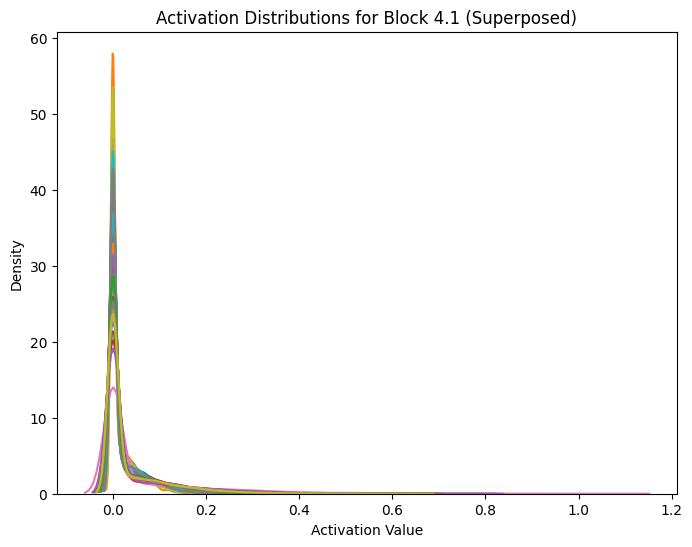

In [ ]:
plot_superposed_distributions(activations_block_2_1, "layer 7",True)
plot_superposed_distributions(activations_block_4_1, "layer 21",True)

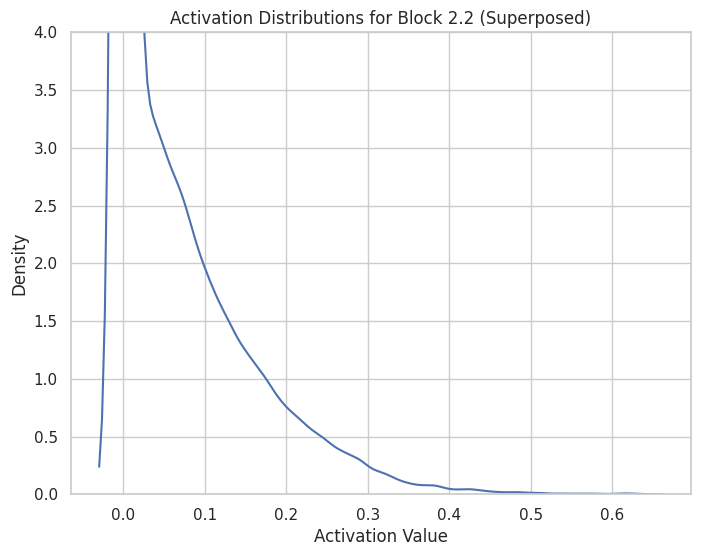

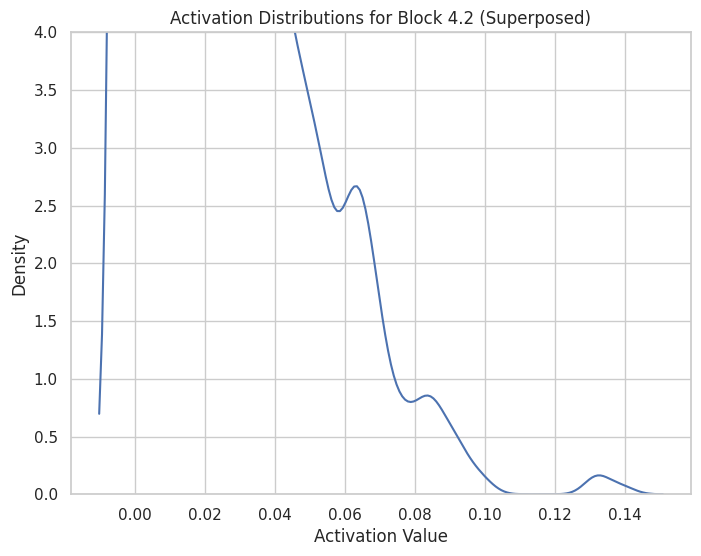

In [ ]:
plot_superposed_distributions(activations_block_2_2_BatchNorm, "Layer 7",False)
plot_superposed_distributions(activations_block_4_2_BatchNorm, "Layer 21",False)

## Loss Landscape

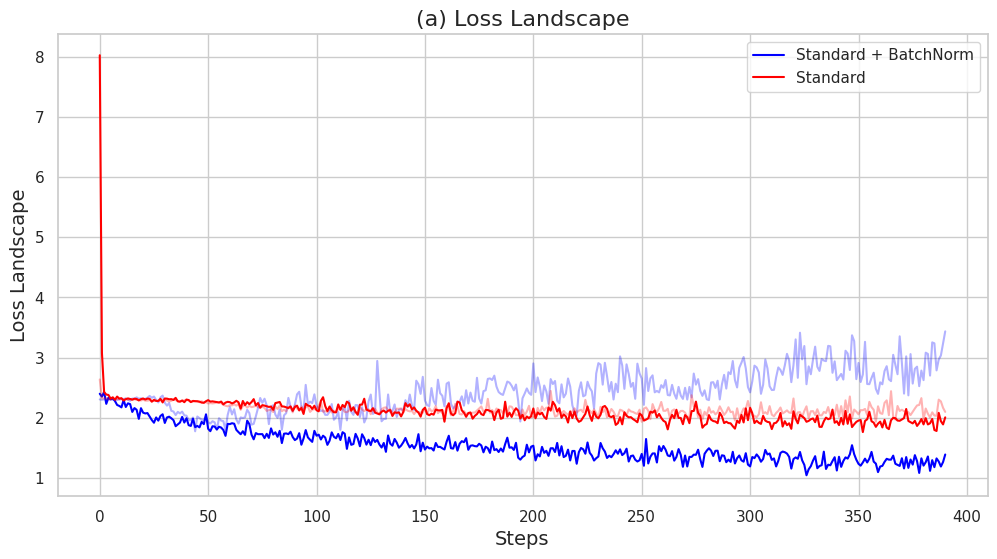

In [ ]:
loss_array_BatchNorm = np.array(loss_values_BatchNorm)
loss_perturbated_array_BatchNorm = np.array(loss_perturbated_BatchNorm)
loss_array = np.array(loss_values)
loss_perturbated_array = np.array(loss_perturbated)

plt.figure(figsize=(12,6))
sns.set(style="whitegrid")

plt.plot(loss_array_BatchNorm, color='blue', label="Standard + BatchNorm")

plt.plot(range(len(loss_array_BatchNorm)), loss_perturbated_array_BatchNorm, color='blue', alpha=0.3)
plt.plot(loss_array, color='red', label="Standard")
plt.plot(range(len(loss_array)), loss_array_BatchNorm, color='red', alpha=0.3)

plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss Landscape", fontsize=14)
plt.legend()
plt.title("(a) Loss Landscape", fontsize=16)

# Display the plot
plt.show()